# Funciones Necesarias

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import threading

In [2]:
def historico(symbol, interval='1d', startTime=None, endTime=None, limit=1000):

    url = 'https://api.binance.com/api/v3/klines'

    params = {'symbol':symbol, 'interval':interval,
              'startTime':startTime, 'endTime':endTime, 'limit':limit}

    r = requests.get(url, params=params)
    js = r.json()

    # Armo el dataframe
    cols = ['openTime','Open','High','Low','Close','Volume','cTime',
            'qVolume','trades','takerBase','takerQuote','Ignore']

    df = pd.DataFrame(js, columns=cols)

    #Convierto los valores strings a numeros
    df = df.apply(pd.to_numeric)

    # Le mando indice de timestamp
    df.index = pd.to_datetime(df.openTime, unit='ms')

    # Elimino columnas que no quiero
    df =df.drop(['openTime','cTime','takerBase','takerQuote','Ignore'],axis=1)

    return df

#historico('BTCUSDT', interval='2h')

In [3]:
def historico_binance(par, inicio, timeframe_minutos=1, n_threads=30):

    ts = int(datetime.timestamp(inicio))*1000
    fechas = []
    while ts < int(datetime.timestamp(datetime.now()))*1000:
        fechas.append((ts, ts+60*1000*1000*timeframe_minutos))
        ts += 60*1000*1000*timeframe_minutos

    intervalos = {1:'1m',5:'5m',15:'15m',30:'30m',60:'1h',1440:'1d'}
    interval = intervalos.get(timeframe_minutos)
    subs = np.array_split(fechas, n_threads)
    dfs = []
    def worker(fechas):
        for fecha in fechas:
            try:
                df = historico(par, interval=interval, startTime=fecha[0])
            except:
                time.sleep(0.01)
                df = historico(par, interval=interval, startTime=fecha[0])
            dfs.append(df)
        return df


    threads = []
    for i in range(n_threads):
        t = threading.Thread(target=worker, args=(subs[i],))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

    data = pd.concat(dfs).sort_index()
    data.index = pd.to_datetime(data.index)

    return data.dropna()

In [4]:
inicio = datetime(2017,1,1)
df = historico_binance('BTCUSDT', inicio, timeframe_minutos=15, n_threads=30)
df = df.resample('15T').last()
df

,Open,High,Low,Close,Volume,qVolume,trades
openTime,,,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061,9.333621e+03,9.0
2017-08-17 04:15:00,4261.48,4270.41,4261.32,4261.45,9.119865,3.889113e+04,40.0
2017-08-17 04:30:00,4280.00,4310.07,4267.99,4310.07,21.923552,9.408092e+04,58.0
2017-08-17 04:45:00,4310.07,4313.62,4291.37,4308.83,13.948531,6.006047e+04,64.0
2017-08-17 05:00:00,4308.83,4328.69,4304.31,4304.31,5.101153,2.200653e+04,44.0
...,...,...,...,...,...,...,...
2023-09-18 04:00:00,26658.66,26680.00,26618.07,26636.95,217.301360,5.790778e+06,6223.0
2023-09-18 04:15:00,26636.94,26636.95,26599.99,26599.99,180.849580,4.814296e+06,5387.0
2023-09-18 04:30:00,26600.00,26602.19,26567.09,26581.93,195.301210,5.191868e+06,6325.0


<AxesSubplot: title={'center': 'Variacion mediana BTC por horario UTC, timeframe 15min'}, xlabel='horario'>

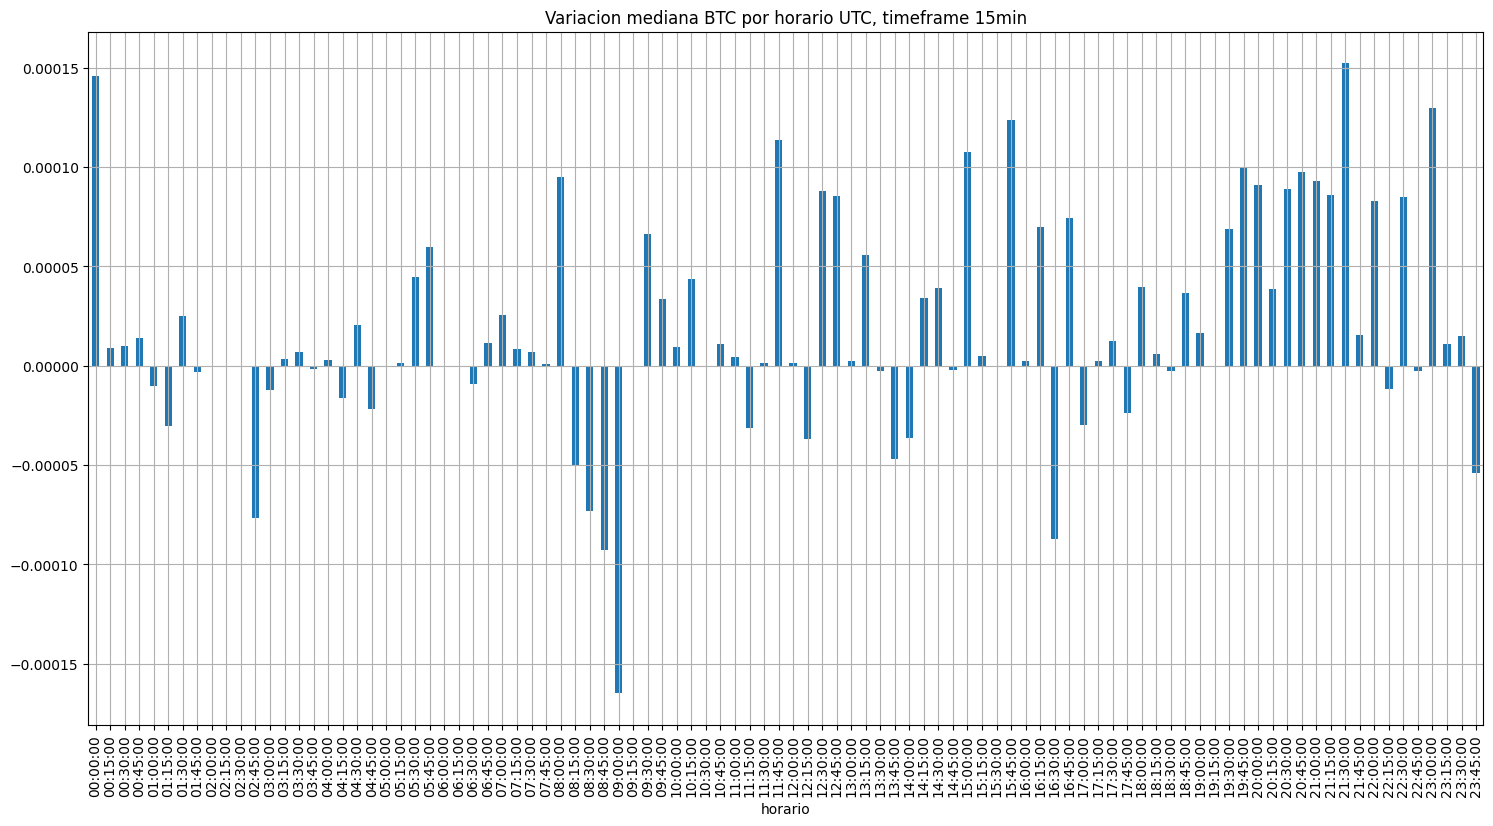

In [5]:
df['horario'] = df.index.time
df['variacion'] = df.Close.pct_change()
agg = df.groupby('horario').variacion.median()
title = 'Variacion mediana BTC por horario UTC, timeframe 15min'
agg.plot(kind='bar', figsize=(18,9), title=title, grid=True)